In [1]:
from __future__ import annotations

import argparse
import random
from dataclasses import dataclass
from typing import Dict, Iterable, List

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
def make_initial_star(k: int) -> nx.DiGraph:
    """
    build a directed star with k leaves around a central hub (node 0)
    leaves 1..k point to hub 0
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(k + 1))
    for i in range(1, k + 1):
        G.add_edge(i, 0)
    return G


def degree_for_attachment(G: nx.DiGraph, node: int) -> int:
    """
    attachment "degree" used for preferential attachment
    use total degree (in+out) so even nodes with only outgoing edges can be selected
    """
    return G.in_degree(node) + G.out_degree(node)


def choose_targets(G: nx.DiGraph, m: int, rng: np.random.Generator) -> List[int]:
    """
    choose m distinct target nodes from existing nodes with probability
    proportional to their current attachment degrees. if all degrees are zero,
    choose uniformly at random
    """
    nodes = np.array(list(G.nodes()))
    weights = np.array([degree_for_attachment(G, int(n)) for n in nodes], dtype=float)
    probs = np.ones_like(weights) / len(weights) if weights.sum() == 0 else weights / weights.sum()
    #sample without replacement according to probs
    targets = rng.choice(nodes, size=m, replace=False, p=probs)
    return [int(t) for t in targets.tolist()]

In [4]:
def barabasi_albert_directed(k: int, N: int, m: int, seed: int | None = 7) -> nx.DiGraph:
    """
    construct a directed network with preferential attachment
    start from a directed star of size k+1 (node 0 hub), then for each new node u:
      - add u
      - connect u -> m existing distinct nodes chosen with probability
        proportional to their current total degree.
    no self-loops.
    """
    if k < 1:
        raise ValueError("k must be >= 1")
    if N <= k + 1:
        raise ValueError("N must be > k+1 (we add nodes after the initial star).")
    if m < 1:
        raise ValueError("m must be >= 1")
    if m > k + 1:
        #only relevant for the first addition
        raise ValueError("m must be <= initial number of nodes (k+1).")

    rng = np.random.default_rng(seed)
    G = make_initial_star(k)
    next_id = k + 1
    while next_id < N:
        G.add_node(next_id)
        targets = choose_targets(G, m, rng)
        for t in targets:
            if t != next_id:
                G.add_edge(next_id, t)
        next_id += 1
    return G

In [5]:
def pagerank_simulation(
    G: nx.DiGraph,
    alpha: float = 0.85,
    steps: int = 200_000,
    seed: int | None = 7,
) -> Dict[int, float]:
    """
    estimate PageRank with a random-surfer Monte Carlo simulation

    alpha: probability to follow an outgoing link; (1 - alpha): teleport
    steps: number of transitions (more -> more accurate)
    seed: random seed for reproducibility

    returns a dict node -> estimated PageRank (sums to ~1)
    """
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0, 1)")
    if steps < 1:
        raise ValueError("steps must be >= 1")
    rnd = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)
    counts = {u: 0 for u in nodes}
    current = rnd.choice(nodes)  #random start

    for _ in range(steps):
        has_out = G.out_degree(current) > 0
        follow_link = (rnd.random() < alpha) and has_out
        if follow_link:
            current = rnd.choice(list(G.successors(current)))
        else:
            current = rnd.choice(nodes)
        counts[current] += 1

    total = float(steps)
    return {u: counts[u] / total for u in nodes}


In [8]:
class RunConfig:
    k: int = 5
    N: int = 400
    m: int = 4
    alpha: float = 0.85
    steps: int = 250_000
    seed: int = 7
    top_n: int = 15
    out_prefix: str = "ba_pr"


def plot_network(G: nx.DiGraph, pr: Dict[int, float], seed: int, out_path: str) -> None:
    """Plot the network with node size proportional to estimated PageRank."""
    pos = nx.spring_layout(G, seed=seed)  #deterministic layout
    sizes = np.array([4000 * pr[n] for n in G.nodes()])
    plt.figure(figsize=(9, 8))
    nx.draw_networkx_nodes(G, pos, node_size=sizes)
    nx.draw_networkx_edges(G, pos, arrows=False, width=0.3, alpha=0.4)
    plt.title("Generated network (node size ∝ estimated PageRank)")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_path, dpi=180)
    plt.close()


def plot_pr_distribution(pr: Dict[int, float], out_path: str) -> None:
    """Plot sorted PageRank values to show heavy-tail behavior."""
    sorted_pr = np.array(sorted(pr.values(), reverse=True))
    plt.figure(figsize=(9, 4.5))
    plt.plot(sorted_pr)
    plt.xlabel("Node rank")
    plt.ylabel("Estimated PageRank")
    plt.title("PageRank distribution (random-surfer simulation)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=180)
    plt.close()


def save_top_pagerank(pr: Dict[int, float], top_n: int, out_path: str) -> pd.DataFrame:
    """Save top-N nodes by PageRank to CSV and return the DataFrame."""
    top = sorted(pr.items(), key=lambda kv: kv[1], reverse=True)[:top_n]
    df = pd.DataFrame(top, columns=["node", "estimated_pagerank"])
    df.to_csv(out_path, index=False)
    return df

In [11]:
def parse_args() -> RunConfig:
    p = argparse.ArgumentParser(description="BA-like directed network + PageRank simulation")
    p.add_argument("--k", type=int, default=5, help="initial star leaves (k)")
    p.add_argument("--N", type=int, default=400, help="total number of nodes/pages")
    p.add_argument("--m", type=int, default=4, help="new out-links per added page")
    p.add_argument("--alpha", type=float, default=0.85, help="prob. to follow a link (1-alpha: teleport)")
    p.add_argument("--steps", type=int, default=250_000, help="random-surfer steps")
    p.add_argument("--seed", type=int, default=7, help="random seed")
    p.add_argument("--top_n", type=int, default=15, help="how many top PR nodes to export")
    p.add_argument("--out_prefix", type=str, default="ba_pr", help="prefix for output files")
    a = p.parse_args()
    return RunConfig(
        k=a.k, N=a.N, m=a.m, alpha=a.alpha, steps=a.steps,
        seed=a.seed, top_n=a.top_n, out_prefix=a.out_prefix
    )


def main(cfg: RunConfig) -> None:
    print(f"Generating BA-like directed graph: k={cfg.k}, N={cfg.N}, m={cfg.m}, seed={cfg.seed}")
    G = barabasi_albert_directed(k=cfg.k, N=cfg.N, m=cfg.m, seed=cfg.seed)

    print(f"Simulating PageRank: alpha={cfg.alpha}, steps={cfg.steps}")
    pr = pagerank_simulation(G, alpha=cfg.alpha, steps=cfg.steps, seed=cfg.seed)

    # Outputs
    net_png = f"{cfg.out_prefix}_network.png"
    dist_png = f"{cfg.out_prefix}_pr_dist.png"
    top_csv = f"{cfg.out_prefix}_top{cfg.top_n}.csv"

    print(f"Saving network plot -> {net_png}")
    plot_network(G, pr, cfg.seed, net_png)

    print(f"Saving PageRank distribution -> {dist_png}")
    plot_pr_distribution(pr, dist_png)

    print(f"Saving top-{cfg.top_n} PageRank nodes -> {top_csv}")
    df = save_top_pagerank(pr, cfg.top_n, top_csv)
    print(df.to_string(index=False))
    print("Done.")
    
if __name__ == "__main__":
    cfg = parse_args()
    #make RNGs deterministic across numpy/random/matplotlib for reproducibility.
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    main(cfg)


usage: ipykernel_launcher.py [-h] [--k K] [--N N] [--m M] [--alpha ALPHA] [--steps STEPS] [--seed SEED]
                             [--top_n TOP_N] [--out_prefix OUT_PREFIX]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Rado\AppData\Roaming\jupyter\runtime\kernel-2f166e25-f781-4d5a-b1c8-ba3fc2c0f12a.json


SystemExit: 2

In [12]:

import argparse, sys

def parse_args():
    p = argparse.ArgumentParser(description="BA-like directed network + PageRank")
    p.add_argument("--k", type=int, default=5)
    p.add_argument("--N", type=int, default=400)
    p.add_argument("--m", type=int, default=4)
    p.add_argument("--alpha", type=float, default=0.85)
    p.add_argument("--steps", type=int, default=250_000)
    p.add_argument("--seed", type=int, default=7)
    p.add_argument("--top_n", type=int, default=15)
    p.add_argument("--out_prefix", type=str, default="ba_pr")
    #ignore notebook’s own args
    args, _ = p.parse_known_args(sys.argv[1:])
    return args


In [ ]:
#install if needed
%pip install -q networkx matplotlib numpy pandas

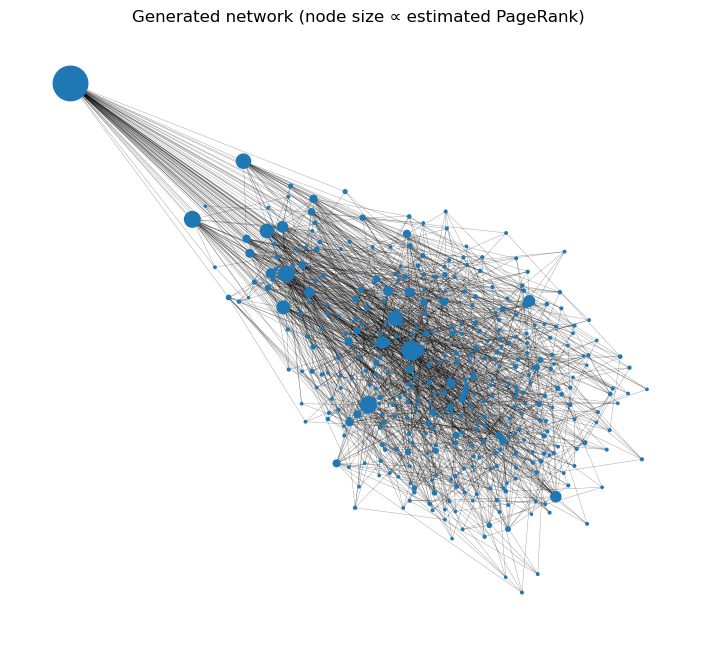

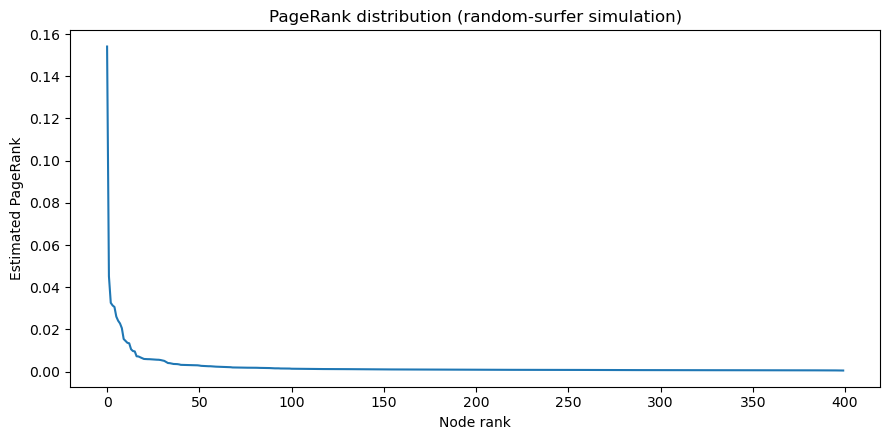

,node,estimated_pagerank
0,0,0.154064
1,6,0.045244
2,3,0.032636
3,4,0.031384
4,8,0.030668
5,1,0.026100
6,10,0.024140
7,11,0.022872
8,7,0.020660
9,19,0.015488


In [13]:
import random
from typing import Dict, List
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------ core helpers ------------------------ #
def make_initial_star(k: int) -> nx.DiGraph:
    G = nx.DiGraph()
    G.add_nodes_from(range(k + 1))
    for i in range(1, k + 1):
        G.add_edge(i, 0)
    return G

def degree_for_attachment(G: nx.DiGraph, node: int) -> int:
    return G.in_degree(node) + G.out_degree(node)

def choose_targets(G: nx.DiGraph, m: int, rng: np.random.Generator) -> List[int]:
    nodes = np.array(list(G.nodes()))
    weights = np.array([degree_for_attachment(G, int(n)) for n in nodes], dtype=float)
    probs = np.ones_like(weights) / len(weights) if weights.sum() == 0 else weights / weights.sum()
    targets = rng.choice(nodes, size=m, replace=False, p=probs)
    return [int(t) for t in targets.tolist()]

def barabasi_albert_directed(k: int, N: int, m: int, seed: int = 7) -> nx.DiGraph:
    if m > k + 1:
        raise ValueError("m must be <= k+1 for the first step.")
    rng = np.random.default_rng(seed)
    G = make_initial_star(k)
    next_id = k + 1
    while next_id < N:
        G.add_node(next_id)
        for t in choose_targets(G, m, rng):
            if t != next_id:
                G.add_edge(next_id, t)
        next_id += 1
    return G

def pagerank_simulation(G: nx.DiGraph, alpha: float = 0.85, steps: int = 200_000, seed: int = 7) -> Dict[int, float]:
    rnd = random.Random(seed)
    nodes = list(G.nodes())
    counts = {u: 0 for u in nodes}
    current = rnd.choice(nodes)
    for _ in range(steps):
        if rnd.random() < alpha and G.out_degree(current) > 0:
            current = rnd.choice(list(G.successors(current)))
        else:
            current = rnd.choice(nodes)
        counts[current] += 1
    total = float(steps)
    return {u: counts[u] / total for u in nodes}

# ------------------------ parameters ------------------------ #
k = 5       # initial star leaves
N = 400     # total nodes
m = 4       # new out-links per added node
alpha = 0.85
steps = 250_000
seed = 7
top_n = 15

# ------------------------ run ------------------------ #
np.random.seed(seed); random.seed(seed)
G = barabasi_albert_directed(k, N, m, seed)
pr = pagerank_simulation(G, alpha, steps, seed)

# network plot
pos = nx.spring_layout(G, seed=seed)
sizes = np.array([4000 * pr[n] for n in G.nodes()])
plt.figure(figsize=(9, 8))
nx.draw_networkx_nodes(G, pos, node_size=sizes)
nx.draw_networkx_edges(G, pos, arrows=False, width=0.3, alpha=0.4)
plt.title("Generated network (node size ∝ estimated PageRank)")
plt.axis("off"); plt.show()

# PR distribution
sorted_pr = np.array(sorted(pr.values(), reverse=True))
plt.figure(figsize=(9, 4.5))
plt.plot(sorted_pr)
plt.xlabel("Node rank"); plt.ylabel("Estimated PageRank")
plt.title("PageRank distribution (random-surfer simulation)")
plt.tight_layout(); plt.show()

# top table
top = sorted(pr.items(), key=lambda kv: kv[1], reverse=True)[:top_n]
pd.DataFrame(top, columns=["node", "estimated_pagerank"])
